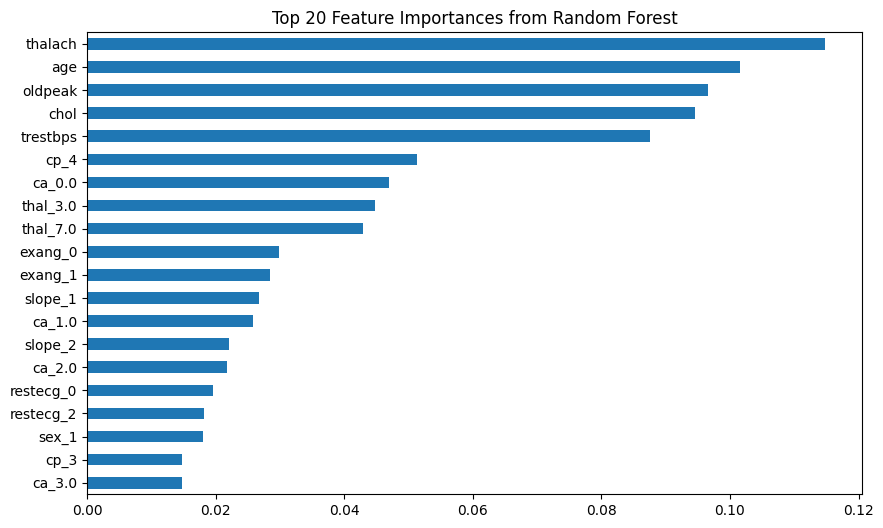

Selected features by RFE:
['oldpeak', 'sex_1', 'cp_1', 'cp_4', 'fbs_1', 'restecg_0', 'exang_1', 'slope_1', 'slope_2', 'ca_0.0', 'ca_2.0', 'ca_3.0', 'ca_nan', 'thal_3.0', 'thal_7.0']


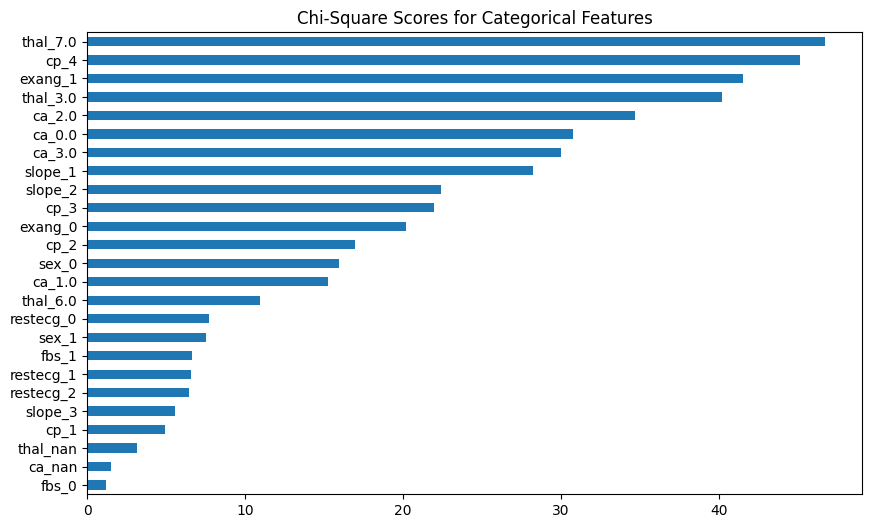

Selected features saved to ../models/selected_features.json


In [1]:
import pandas as pd
import json
import os
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE, SelectKBest, chi2
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

# 1. Load cleaned data and columns info
df = pd.read_csv('../data/heart_disease_clean.csv')
with open('../models/cols.json', 'r') as f:
    cols = json.load(f)
num_cols = cols['num_cols']
cat_cols = cols['cat_cols']

# 2. Separate X and y
X = df.drop('target', axis=1)
y = df['target']

# 3. Preprocess features for model input

# For Random Forest, encoding categoricals with OneHotEncoder, scaling numeric is optional but safe
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
    ]
)

X_processed = preprocessor.fit_transform(X)

# Get feature names after encoding
encoded_cat_cols = preprocessor.named_transformers_['cat'].get_feature_names_out(cat_cols)
all_features = num_cols + list(encoded_cat_cols)

# 4. Random Forest for feature importance
rf = RandomForestClassifier(random_state=42, n_estimators=100)
rf.fit(X_processed, y)
importances = rf.feature_importances_

# Sort and plot feature importances
feat_imp = pd.Series(importances, index=all_features).sort_values(ascending=False)

plt.figure(figsize=(10,6))
feat_imp.head(20).plot(kind='barh')
plt.gca().invert_yaxis()
plt.title('Top 20 Feature Importances from Random Forest')
plt.show()

# 5. Recursive Feature Elimination (RFE) with Logistic Regression for simplicity
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(max_iter=1000)
rfe = RFE(logreg, n_features_to_select=15)  # adjust 15 to desired number of features
rfe.fit(X_processed, y)

rfe_features = pd.Series(rfe.support_, index=all_features)
selected_features = list(rfe_features[rfe_features].index)

print("Selected features by RFE:")
print(selected_features)

# 6. Chi-Square Test for categorical features (needs positive data, so scale numeric aside)
# Only apply chi2 on encoded categorical columns because it requires non-negative data
X_cat = preprocessor.named_transformers_['cat'].transform(X[cat_cols])
chi2_selector = SelectKBest(chi2, k='all')
chi2_selector.fit(X_cat, y)
chi2_scores = pd.Series(chi2_selector.scores_, index=encoded_cat_cols).sort_values(ascending=False)

plt.figure(figsize=(10,6))
chi2_scores.plot(kind='barh')
plt.gca().invert_yaxis()
plt.title('Chi-Square Scores for Categorical Features')
plt.show()

# 7. Save selected features for next steps (you decide how to combine RF, RFE, Chi2)
selected_dict = {
    'rf_top_20': list(feat_imp.head(20).index),
    'rfe_selected': selected_features,
    'chi2_scores': chi2_scores.index.tolist()
}

os.makedirs('../models', exist_ok=True)
import json
json.dump(selected_dict, open('../models/selected_features.json', 'w'))
print("Selected features saved to ../models/selected_features.json")
